<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter4GeometricImaging/projectionTomography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Projection Tomography
###David Brady
### University of Arizona

Section 4.3 of **Computational Optical Imaging**

### Python modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy import signal
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from skimage.transform import radon, rescale,  resize, warp, iradon
from scipy import interpolate
from skimage.transform import iradon_sart


### load mnist data set as example images

In [2]:
from keras.datasets import mnist
# load the mnist dataset of characters
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

11490434/11490434 [==============================] - 1s 0us/step


## Sinograms of various images

/usr/local/lib/python3.10/dist-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


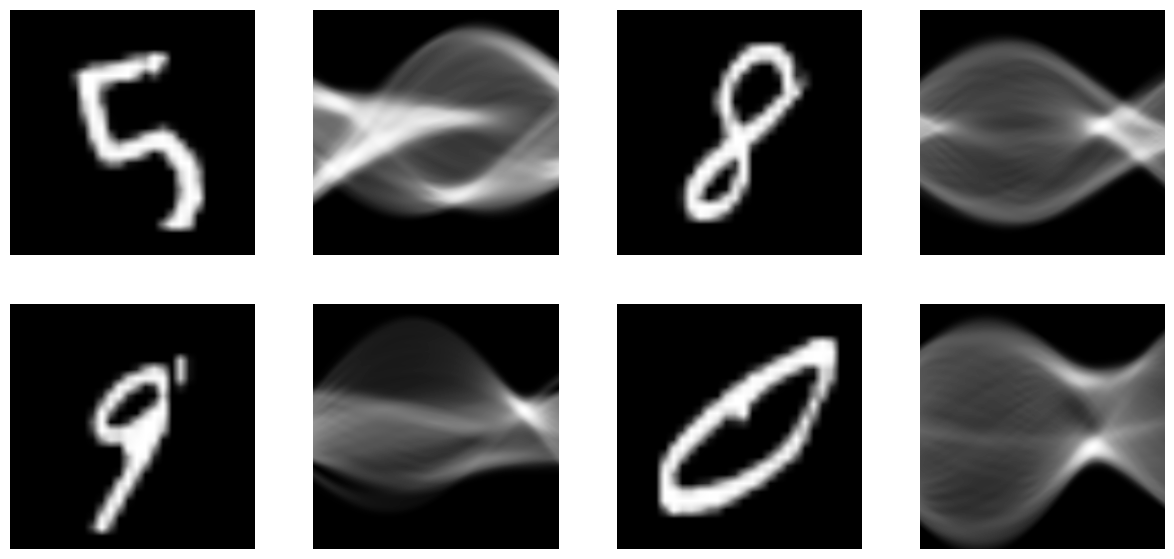

In [9]:
# code from https://scikit-image.org/docs/dev/auto_examples/transform/plot_radon_transform.html


fig, ax = plt.subplots(2, 4, figsize=(15, 7))
nP=256
imageInex=[1024, 1025, 1027,  1029]
for i in imageInex:
  image=x_train[i,:,:]
  image = resize(image, (nP,nP), mode='edge')
  plt.subplot(2,4,2*imageInex.index(i)+1)
  plt.imshow(image, cmap=plt.cm.Greys_r)
  plt.axis('off')
  theta = np.linspace(0., 180., max(image.shape), endpoint=False)
  sinogram = radon(image, theta=theta)
  dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
  plt.subplot(2,4,2*imageInex.index(i)+2)
  plt.imshow(sinogram, cmap=plt.cm.Greys_r)
  plt.axis('off')

plt.savefig('mnistSinograms.pdf')
#files.download('mnistSinograms.pdf')


In [8]:
sinogram.shape

(256, 256)

## Explicit convolution backprojection example

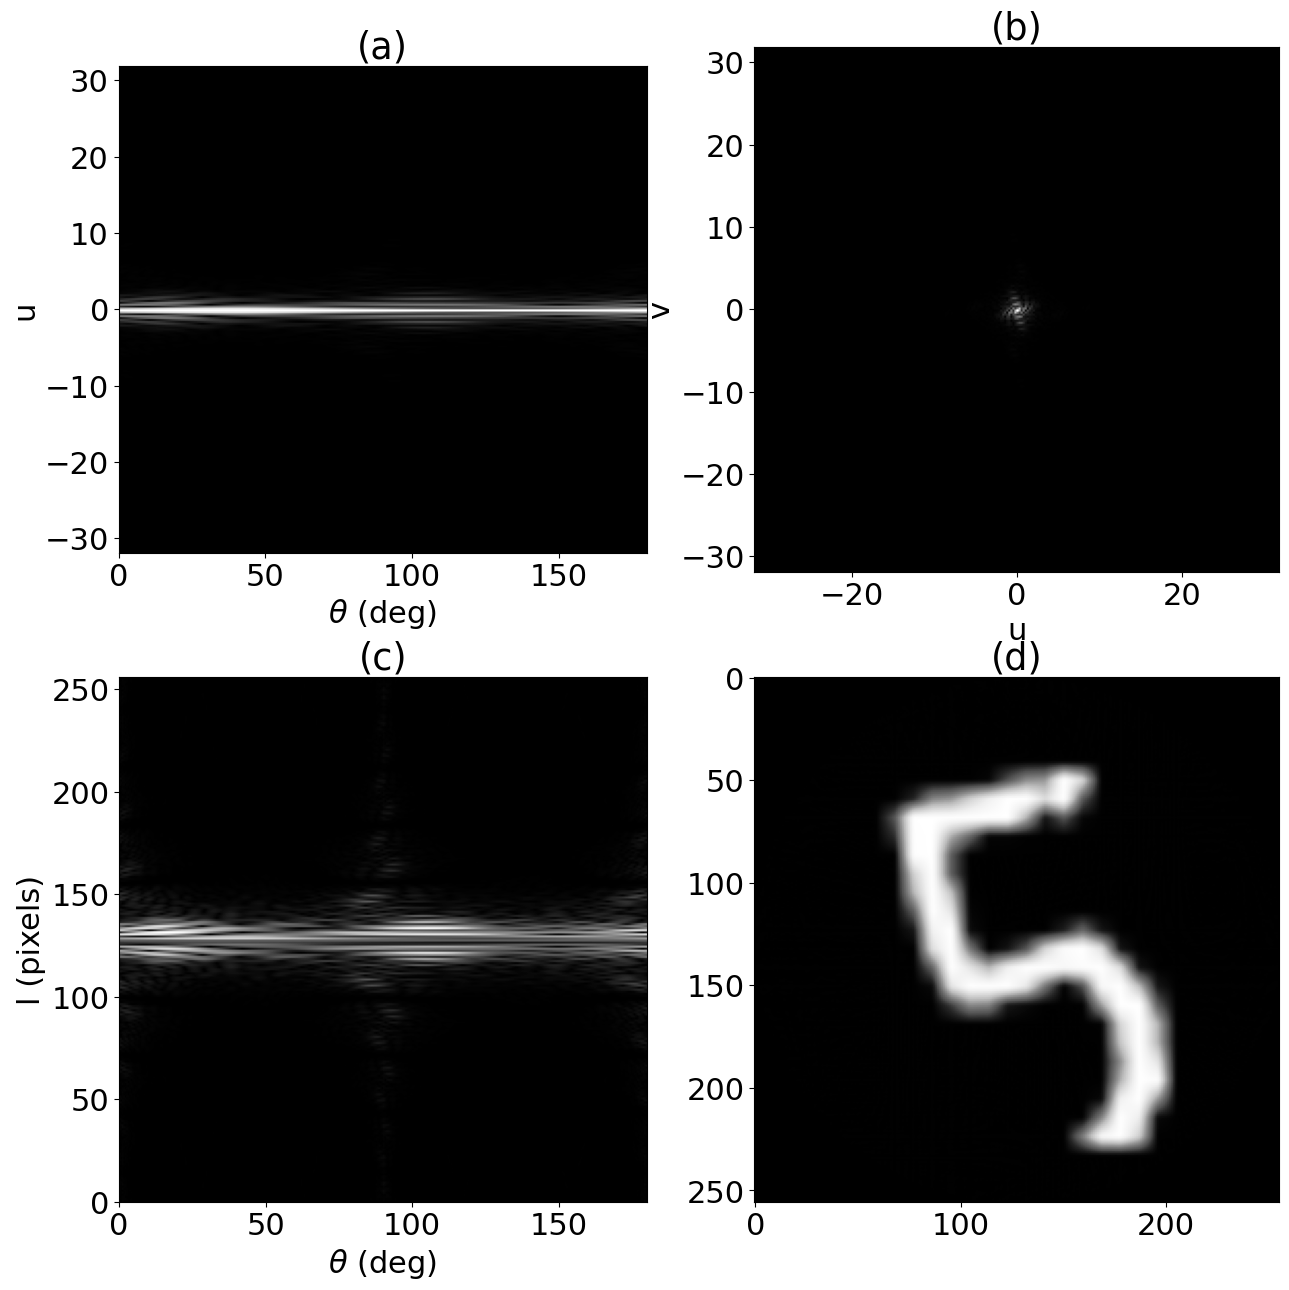

In [3]:
xMax=2;
nP=256;
xStep=2*xMax/(nP-1);
uMax=1/(2*xStep);uStep=2*uMax/(nP-1);
urange=np.linspace(-uMax,uMax,nP);
xrange=np.linspace(-xMax,xMax,nP);
thetaRange=np.arange(0,180,.5);
[x,y]=np.meshgrid(xrange,xrange);
[v,u]=np.meshgrid(thetaRange,urange);
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
image=x_train[1024,:,:]
image = resize(image, (nP,nP), mode='edge')
rTf1=radon(image,thetaRange);
ftR=np.fft.fftshift(np.fft.fft(np.fft.fftshift(rTf1,axes=0),axis=0),axes=0);
Q=np.fft.fftshift(np.fft.fft(np.fft.fftshift(ftR*u,axes=0),axis=0),axes=0);
ax[0,0].imshow(np.abs(ftR), cmap=plt.cm.Greys_r, extent = (0 , 180,-uMax  ,uMax) );
ax[0,0].set_title('(a)')
ax[0,0].set_xlabel(r'$\theta$ (deg)')
ax[0,0].set_ylabel("u")
ax[0,0].set_aspect(2.6)
ax[0,1].imshow(abs(np.fft.fftshift(np.fft.fft2(image))),cmap=plt.cm.Greys_r,extent = (-uMax,uMax,-uMax,uMax));
ax[0,1].set_title('(b)')
ax[0,1].set_aspect('equal')
ax[0,1].set_xlabel("u")
ax[0,1].set_ylabel("v")
recon= iradon(rTf1,theta=thetaRange)
ax[1,0].imshow(np.transpose(np.abs(np.fft.fftshift(np.fft.fft(np.fft.fftshift(np.transpose(Q), axes=1)),axes=1))),cmap=plt.cm.Greys_r,extent=[0 , 180, 0  ,256]);
ax[1,0].set_aspect(.7)
ax[1,0].set_title('(c)')
ax[1,0].set_xlabel(r"$\theta$ (deg)")
ax[1,0].set_ylabel("l (pixels)")
ax[1,1].imshow(recon,cmap=plt.cm.Greys_r);
ax[1,1].set_title('(d)')
plt.savefig('mnistRadon.pdf')
#files.download('mnistRadon.pdf')


## modified iradon function

here we modify the iradon function from https://github.com/scikit-image/scikit-image to also return the filtered projections $Q(l,\theta)$

In [ ]:
from scipy.interpolate import interp1d
from scipy.constants import golden_ratio
from skimage.transform._warps import warp
from skimage.transform._radon_transform import sart_projection_update
from skimage._shared.fft import fftmodule
from skimage._shared.utils import  convert_to_float
from warnings import warn
from functools import partial

if fftmodule is np.fft:
    # fallback from scipy.fft to scipy.fftpack instead of numpy.fft
    # (fftpack preserves single precision while numpy.fft does not)
    from scipy.fftpack import fft, ifft
else:
    fft = fftmodule.fft
    ifft = fftmodule.ifft

def iradon(radon_image, theta=None, output_size=None,
           filter_name="ramp", interpolation="linear", circle=True,
           preserve_range=True):
    """Inverse radon transform.

    Reconstruct an image from the radon transform, using the filtered
    back projection algorithm.

    Parameters
    ----------
    radon_image : array
        Image containing radon transform (sinogram). Each column of
        the image corresponds to a projection along a different
        angle. The tomography rotation axis should lie at the pixel
        index ``radon_image.shape[0] // 2`` along the 0th dimension of
        ``radon_image``.
    theta : array_like, optional
        Reconstruction angles (in degrees). Default: m angles evenly spaced
        between 0 and 180 (if the shape of `radon_image` is (N, M)).
    output_size : int, optional
        Number of rows and columns in the reconstruction.
    filter_name : str, optional
        Filter used in frequency domain filtering. Ramp filter used by default.
        Filters available: ramp, shepp-logan, cosine, hamming, hann.
        Assign None to use no filter.
    interpolation : str, optional
        Interpolation method used in reconstruction. Methods available:
        'linear', 'nearest', and 'cubic' ('cubic' is slow).
    circle : boolean, optional
        Assume the reconstructed image is zero outside the inscribed circle.
        Also changes the default output_size to match the behaviour of
        ``radon`` called with ``circle=True``.
    preserve_range : bool, optional
        Whether to keep the original range of values. Otherwise, the input
        image is converted according to the conventions of `img_as_float`.
        Also see https://scikit-image.org/docs/dev/user_guide/data_types.html

    Returns
    -------
    reconstructed : ndarray
        Reconstructed image. The rotation axis will be located in the pixel
        with indices
        ``(reconstructed.shape[0] // 2, reconstructed.shape[1] // 2)``.

    .. versionchanged :: 0.19
        In ``iradon``, ``filter`` argument is deprecated in favor of
        ``filter_name``.

    References
    ----------
    .. [1] AC Kak, M Slaney, "Principles of Computerized Tomographic
           Imaging", IEEE Press 1988.
    .. [2] B.R. Ramesh, N. Srinivasa, K. Rajgopal, "An Algorithm for Computing
           the Discrete Radon Transform With Some Applications", Proceedings of
           the Fourth IEEE Region 10 International Conference, TENCON '89, 1989

    Notes
    -----
    It applies the Fourier slice theorem to reconstruct an image by
    multiplying the frequency domain of the filter with the FFT of the
    projection data. This algorithm is called filtered back projection.

    """
    if radon_image.ndim != 2:
        raise ValueError('The input image must be 2-D')

    if theta is None:
        theta = np.linspace(0, 180, radon_image.shape[1], endpoint=False)

    angles_count = len(theta)
    if angles_count != radon_image.shape[1]:
        raise ValueError("The given ``theta`` does not match the number of "
                         "projections in ``radon_image``.")

    interpolation_types = ('linear', 'nearest', 'cubic')
    if interpolation not in interpolation_types:
        raise ValueError("Unknown interpolation: %s" % interpolation)

    filter_types = ('ramp', 'shepp-logan', 'cosine', 'hamming', 'hann', None)
    if filter_name not in filter_types:
        raise ValueError("Unknown filter: %s" % filter_name)

    radon_image = convert_to_float(radon_image, preserve_range)
    dtype = radon_image.dtype

    img_shape = radon_image.shape[0]
    if output_size is None:
        # If output size not specified, estimate from input radon image
        if circle:
            output_size = img_shape
        else:
            output_size = int(np.floor(np.sqrt((img_shape) ** 2 / 2.0)))

    if circle:
        radon_image = _sinogram_circle_to_square(radon_image)
        img_shape = radon_image.shape[0]

    # Resize image to next power of two (but no less than 64) for
    # Fourier analysis; speeds up Fourier and lessens artifacts
    projection_size_padded = max(64, int(2 ** np.ceil(np.log2(2 * img_shape))))
    pad_width = ((0, projection_size_padded - img_shape), (0, 0))
    img = np.pad(radon_image, pad_width, mode='constant', constant_values=0)

    # Apply filter in Fourier domain
    fourier_filter = _get_fourier_filter(projection_size_padded, filter_name)
    projection = fft(img, axis=0) * fourier_filter
    radon_filtered = np.real(ifft(projection, axis=0)[:img_shape, :])

    # Reconstruct image by interpolation
    reconstructed = np.zeros((output_size, output_size),
                             dtype=dtype)
    radius = output_size // 2
    xpr, ypr = np.mgrid[:output_size, :output_size] - radius
    x = np.arange(img_shape) - img_shape // 2

    for col, angle in zip(radon_filtered.T, np.deg2rad(theta)):
        t = ypr * np.cos(angle) - xpr * np.sin(angle)
        if interpolation == 'linear':
            interpolant = partial(np.interp, xp=x, fp=col, left=0, right=0)
        else:
            interpolant = interp1d(x, col, kind=interpolation,
                                   bounds_error=False, fill_value=0)
        reconstructed += interpolant(t)

    if circle:
        out_reconstruction_circle = (xpr ** 2 + ypr ** 2) > radius ** 2
        reconstructed[out_reconstruction_circle] = 0.

    return reconstructed * np.pi / (2 * angles_count), projection
def _sinogram_circle_to_square(sinogram):
    diagonal = int(np.ceil(np.sqrt(2) * sinogram.shape[0]))
    pad = diagonal - sinogram.shape[0]
    old_center = sinogram.shape[0] // 2
    new_center = diagonal // 2
    pad_before = new_center - old_center
    pad_width = ((pad_before, pad - pad_before), (0, 0))
    return np.pad(sinogram, pad_width, mode='constant', constant_values=0)
def _get_fourier_filter(size, filter_name):
    """Construct the Fourier filter.

    This computation lessens artifacts and removes a small bias as
    explained in [1], Chap 3. Equation 61.

    Parameters
    ----------
    size : int
        filter size. Must be even.
    filter_name : str
        Filter used in frequency domain filtering. Filters available:
        ramp, shepp-logan, cosine, hamming, hann. Assign None to use
        no filter.

    Returns
    -------
    fourier_filter: ndarray
        The computed Fourier filter.

    References
    ----------
    .. [1] AC Kak, M Slaney, "Principles of Computerized Tomographic
           Imaging", IEEE Press 1988.

    """
    n = np.concatenate((np.arange(1, size / 2 + 1, 2, dtype=int),
                        np.arange(size / 2 - 1, 0, -2, dtype=int)))
    f = np.zeros(size)
    f[0] = 0.25
    f[1::2] = -1 / (np.pi * n) ** 2

    # Computing the ramp filter from the fourier transform of its
    # frequency domain representation lessens artifacts and removes a
    # small bias as explained in [1], Chap 3. Equation 61
    fourier_filter = 2 * np.real(fft(f))         # ramp filter
    if filter_name == "ramp":
        pass
    elif filter_name == "shepp-logan":
        # Start from first element to avoid divide by zero
        omega = np.pi * fftmodule.fftfreq(size)[1:]
        fourier_filter[1:] *= np.sin(omega) / omega
    elif filter_name == "cosine":
        freq = np.linspace(0, np.pi, size, endpoint=False)
        cosine_filter = fftmodule.fftshift(np.sin(freq))
        fourier_filter *= cosine_filter
    elif filter_name == "hamming":
        fourier_filter *= fftmodule.fftshift(np.hamming(size))
    elif filter_name == "hann":
        fourier_filter *= fftmodule.fftshift(np.hanning(size))
    elif filter_name is None:
        fourier_filter[:] = 1

    return fourier_filter[:, np.newaxis]


## Algebraic Reconstruction from Sparse Data

SART (1 iteration) rms reconstruction error: 0.157
SART (1 iteration) rms reconstruction error: 0.158


/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])


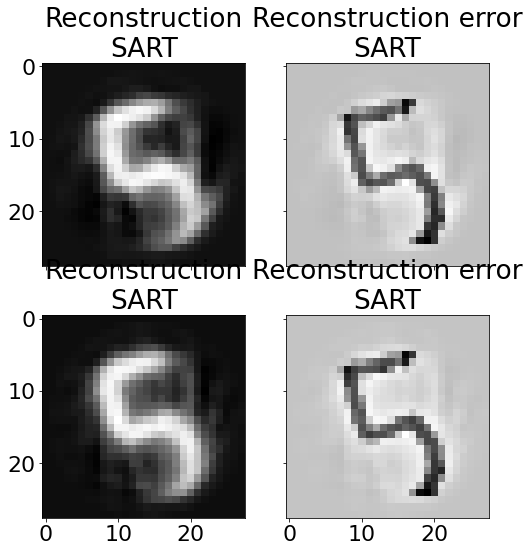

In [ ]:


ntheta=10;
image=x_train[1024,:,:]
thetaVals=np.random.choice(360,ntheta,replace=False)/2.
sinogram=radon(image,thetaVals);
reconstruction_sart = iradon_sart(sinogram, theta=thetaVals)
error = reconstruction_sart - image
print("SART (1 iteration) rms reconstruction error: "
      f"{np.sqrt(np.mean(error**2)):.3g}")

fig, axes = plt.subplots(2, 2, figsize=(8, 8.5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].set_title("Reconstruction\nSART")
ax[0].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

ax[1].set_title("Reconstruction error\nSART")
ax[1].imshow(reconstruction_sart - image, cmap=plt.cm.Greys_r)
# no try with regularly spaced samples
thetaVals=np.linspace(0,180,ntheta)
sinogram=radon(image,thetaVals);
reconstruction_sart = iradon_sart(sinogram, theta=thetaVals)
error = reconstruction_sart - image
print("SART (1 iteration) rms reconstruction error: "
      f"{np.sqrt(np.mean(error**2)):.3g}")

ax[2].set_title("Reconstruction\nSART")
ax[2].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

ax[3].set_title("Reconstruction error\nSART")
ax[3].imshow(reconstruction_sart - image, cmap=plt.cm.Greys_r)


In [ ]:
sinogram.shape

(28, 10)

# Neural compressed sensing

### load and prepare data

In [ ]:
# load the mnist dataset of characters
from keras.datasets import mnist

ntheta=20;
# randomly spaced values of theta
thetaVals=np.random.choice(360,ntheta,replace=False)/2.


(x_train, y_train), (x_test, y_test) = mnist.load_data()
#
# image padding to full radon data from all directions.
#
x_train =np.pad(x_train, ((0,0),(18,18),(18,18)), 'constant')
x_test =np.pad(x_test, ((0,0),(18,18),(18,18)), 'constant')

x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0


g_test=np.zeros(np.shape(x_test))
g_train=np.zeros(np.shape(x_train))
for pop in range(np.shape(x_test)[0]):
  g_test[pop,:,:]= iradon_sart(radon(x_test[pop,:,:],thetaVals), theta=thetaVals)
  g_test[pop,:,:]=g_test[pop,:,:]/np.max(g_test[pop,:,:])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:,:]=iradon_sart(radon(x_train[pop,:,:],thetaVals), theta=thetaVals)
  g_train[pop,:,:]=g_train[pop,:,:]/np.max(g_train[pop,:,:])
x_train = np.reshape(x_train, (len(x_train), 64, 64, 1))
x_test = np.reshape(x_test, (len(x_test), 64, 64, 1))
g_train = np.reshape(g_train, (len(g_train), 64, 64, 1))
g_test = np.reshape(g_test, (len(g_test), 64, 64, 1))

11501568/11490434 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])


1.0


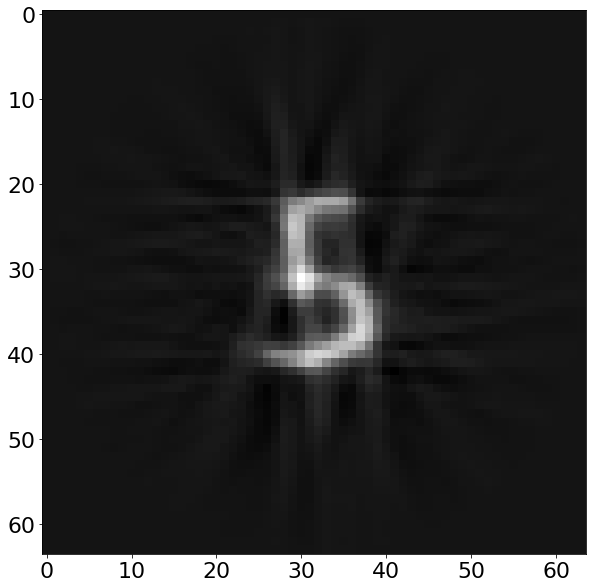

In [ ]:
plt.imshow(g_test[1931].reshape(64, 64))
print(np.max(g_test[1931]))

### Encoder/denoising model

In [ ]:
inputs=keras.Input(shape=(64, 64, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder = keras.Model(inputs, x)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        16416     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 16)        4624  

### Training

In [ ]:
autoencoder.fit(
    x=g_train,
    y=x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/10
469/469 [==============================] - 32s 34ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 2/10
469/469 [==============================] - 15s 33ms/step - loss: 8.2775e-04 - val_loss: 7.3276e-04
Epoch 3/10
469/469 [==============================] - 15s 33ms/step - loss: 6.4737e-04 - val_loss: 6.8205e-04
Epoch 4/10
469/469 [==============================] - 15s 33ms/step - loss: 5.5756e-04 - val_loss: 5.6594e-04
Epoch 5/10
469/469 [==============================] - 15s 33ms/step - loss: 5.0202e-04 - val_loss: 4.5659e-04
Epoch 6/10
469/469 [==============================] - 15s 33ms/step - loss: 4.6101e-04 - val_loss: 4.3481e-04
Epoch 7/10
469/469 [==============================] - 15s 33ms/step - loss: 4.2723e-04 - val_loss: 4.3173e-04
Epoch 8/10
469/469 [==============================] - 15s 33ms/step - loss: 4.0249e-04 - val_loss: 3.7619e-04
Epoch 9/10
469/469 [==============================] - 15s 33ms/step - loss: 3.8346e-04 - val_loss: 3.6360e-04
Epoch 10/10
469/46

### Examples of subsampled and estimated images

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

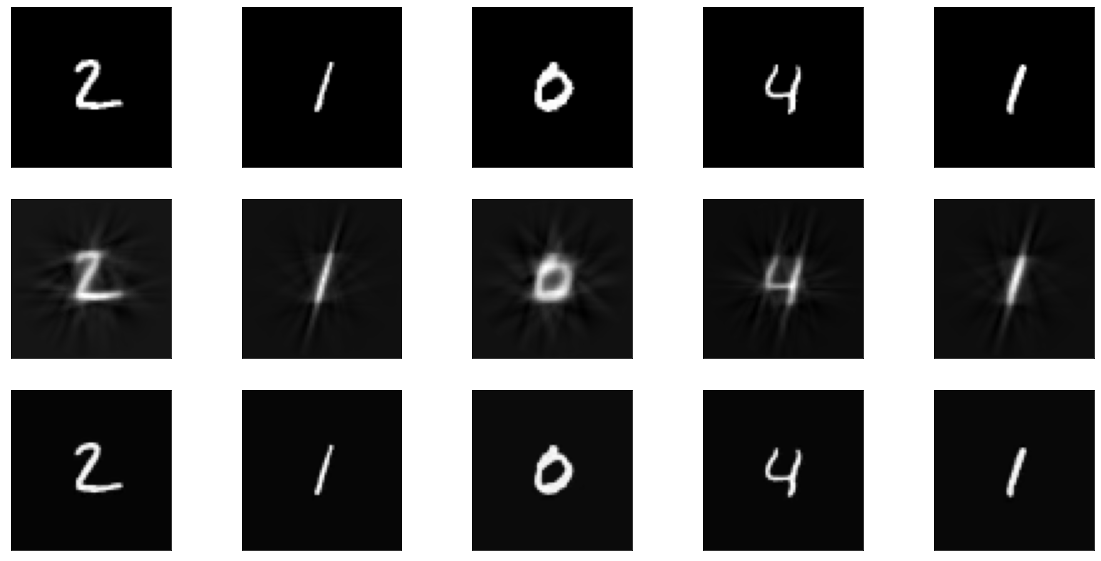

In [ ]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(autoencoder.predict(g_test[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('subSampleSARTNeuralDecompression.pdf')
files.download('subSampleSARTNeuralDecompression.pdf')

# Neural compressed sensing with noise

### load and prepare data

In [ ]:
# load the mnist dataset of characters
from keras.datasets import mnist

ntheta=20;
# randomly spaced values of theta
thetaVals=np.random.choice(360,ntheta,replace=False)/2.
#
# we are going to add poisson noise to the measurements. nPhoto is an gain factor for the intensity of the measured signal
#
nPhoto=1

(x_train, y_train), (x_test, y_test) = mnist.load_data()
#
# image padding to full radon data from all directions.
#
x_train =np.pad(x_train, ((0,0),(18,18),(18,18)), 'constant')
x_test =np.pad(x_test, ((0,0),(18,18),(18,18)), 'constant')

x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0


g_test=np.zeros(np.shape(x_test))
g_train=np.zeros(np.shape(x_train))
for pop in range(np.shape(x_test)[0]):
  g_test[pop,:,:]= iradon_sart(28.*nPhoto-np.random.poisson(nPhoto*(28.-radon(x_test[pop,:,:],thetaVals))), theta=thetaVals)
  g_test[pop,:,:]=g_test[pop,:,:]/np.max(g_test[pop,:,:])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:,:]=iradon_sart(28.*nPhoto-np.random.poisson(nPhoto*(28.-radon(x_train[pop,:,:],thetaVals))), theta=thetaVals)
  g_train[pop,:,:]=g_train[pop,:,:]/np.max(g_train[pop,:,:])
x_train = np.reshape(x_train, (len(x_train), 64, 64, 1))
x_test = np.reshape(x_test, (len(x_test), 64, 64, 1))
g_train = np.reshape(g_train, (len(g_train), 64, 64, 1))
g_test = np.reshape(g_test, (len(g_test), 64, 64, 1))

/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])


### Encoder/denoising model

In [ ]:
inputs=keras.Input(shape=(64, 64, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder = keras.Model(inputs, x)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        16416     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 16)        4624  

### Training

In [ ]:
autoencoder.fit(
    x=g_train,
    y=x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/10
469/469 [==============================] - 32s 35ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 2/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 3/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 4/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 5/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 6/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 7/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 8/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 9/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 10/10
469/469 [==============================] - 16s 34ms/step - loss: 0.004

### Examples of subsampled and estimated images

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

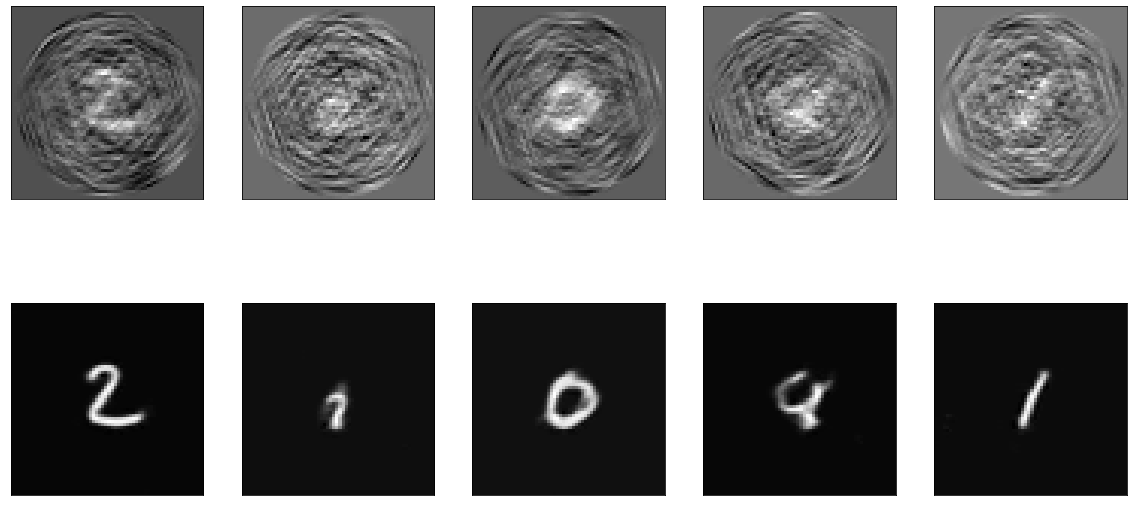

In [ ]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.imshow(g_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, n+i)
    plt.imshow(autoencoder.predict(g_test[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('subSampleSARTNeuralDecompressionNoise20.pdf')
files.download('subSampleSARTNeuralDecompressionNoise20.pdf')

# Neural fully sampled with noise

### load and prepare data

In [ ]:
# load the mnist dataset of characters
from keras.datasets import mnist

ntheta=20*9;
# randomly spaced values of theta
thetaVals=np.random.choice(360,ntheta,replace=False)/2.
#
# we are going to add poisson noise to the measurements. nPhoto is an gain factor for the intensity of the measured signal
#
nPhoto=1/9

(x_train, y_train), (x_test, y_test) = mnist.load_data()
#
# image padding to full radon data from all directions.
#
x_train =np.pad(x_train, ((0,0),(18,18),(18,18)), 'constant')
x_test =np.pad(x_test, ((0,0),(18,18),(18,18)), 'constant')

x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0


g_test=np.zeros(np.shape(x_test))
g_train=np.zeros(np.shape(x_train))
for pop in range(np.shape(x_test)[0]):
  g_test[pop,:,:]= iradon_sart(28.*nPhoto-np.random.poisson(nPhoto*(28.-radon(x_test[pop,:,:],thetaVals))), theta=thetaVals)
  g_test[pop,:,:]=g_test[pop,:,:]/np.max(g_test[pop,:,:])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:,:]=iradon_sart(28.*nPhoto-np.random.poisson(nPhoto*(28.-radon(x_train[pop,:,:],thetaVals))), theta=thetaVals)
  g_train[pop,:,:]=g_train[pop,:,:]/np.max(g_train[pop,:,:])
x_train = np.reshape(x_train, (len(x_train), 64, 64, 1))
x_test = np.reshape(x_test, (len(x_test), 64, 64, 1))
g_train = np.reshape(g_train, (len(g_train), 64, 64, 1))
g_test = np.reshape(g_test, (len(g_test), 64, 64, 1))

/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])


### Encoder/denoising model

In [ ]:
inputs=keras.Input(shape=(64, 64, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder = keras.Model(inputs, x)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        16416     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 16)        4624  

### Training

In [ ]:
autoencoder.fit(
    x=g_train,
    y=x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/10
469/469 [==============================] - 18s 35ms/step - loss: 0.0105 - val_loss: 0.0089
Epoch 2/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0086 - val_loss: 0.0083
Epoch 3/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 4/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 5/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 6/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 7/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 8/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 9/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0068 - val_loss: 0.0070
Epoch 10/10
469/469 [==============================] - 16s 34ms/step - loss: 0.006

### Examples of subsampled and estimated images

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

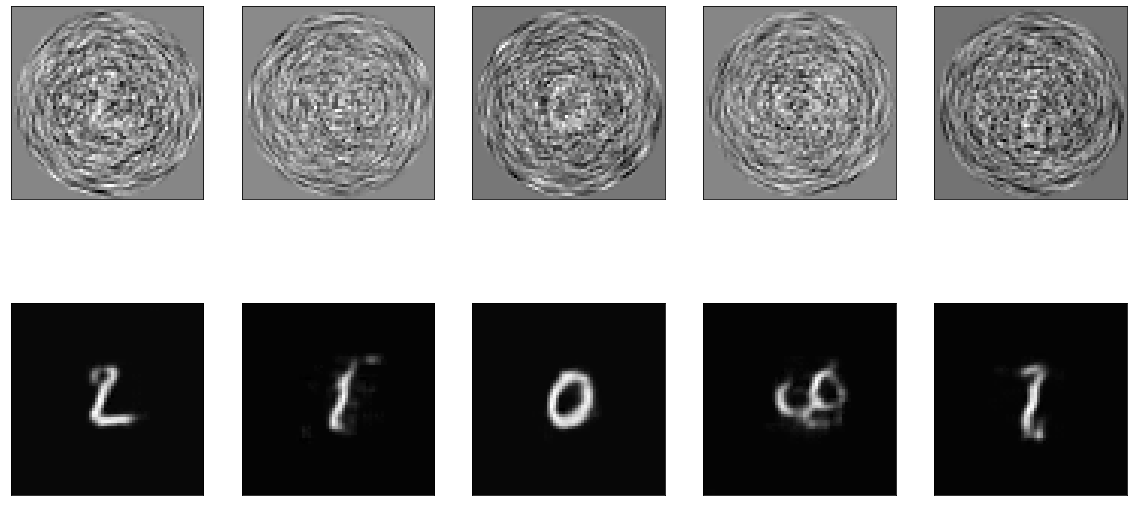

In [ ]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.imshow(g_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, n+i)
    plt.imshow(autoencoder.predict(g_test[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('subSampleSARTNeuralDecompressionNoisefull.pdf')
files.download('subSampleSARTNeuralDecompressionNoisefull.pdf')